<a href="https://colab.research.google.com/github/ABHINAV-GOPINADH/deep_Learning/blob/main/netflix_stock_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"abhinavkgedit","key":"ebd09ad3e487213b8bc2e77fd8095289"}'}

In [ ]:
import os
import zipfile

# Create the .kaggle folder
os.makedirs("/root/.kaggle", exist_ok=True)

# Move kaggle.json into the folder
!mv kaggle.json /root/.kaggle/

# Set permission
!chmod 600 /root/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d umerhaddii/netflix-stock-data-2025
!unzip netflix-stock-data-2025.zip -d netflix_data

Dataset URL: https://www.kaggle.com/datasets/umerhaddii/netflix-stock-data-2025
License(s): CC0-1.0
  0% 0.00/133k [00:00<?, ?B/s]
100% 133k/133k [00:00<00:00, 411MB/s]
Archive:  netflix-stock-data-2025.zip
  inflating: netflix_data/NFLX_stocks.csv  


In [ ]:
import pandas as pd
df = pd.read_csv("/content/netflix_data/NFLX_stocks.csv")
df.head()



,date,open,high,low,close,adj_close,volume
0,NaN,NFLX,NFLX,NFLX,NFLX,NFLX,NFLX
1,2002-05-23,1.1564290523529053,1.2428569793701172,1.1457140445709229,1.1964290142059326,1.1964290142059326,104790000
2,2002-05-24,1.214285969734192,1.225000023841858,1.1971429586410522,1.2100000381469727,1.2100000381469727,11104800
3,2002-05-28,1.2135709524154663,1.2321430444717407,1.157142996788025,1.157142996788025,1.157142996788025,6609400
4,2002-05-29,1.1642860174179077,1.1642860174179077,1.0857139825820923,1.1035710573196411,1.1035710573196411,6757800


In [ ]:
print(df.columns)

Index(['date', 'open', 'high', 'low', 'close', 'adj_close', 'volume'], dtype='object')


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5803 entries, 0 to 5802
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   date       5802 non-null   object
 1   open       5803 non-null   object
 2   high       5803 non-null   object
 3   low        5803 non-null   object
 4   close      5803 non-null   object
 5   adj_close  5803 non-null   object
 6   volume     5803 non-null   object
dtypes: object(7)
memory usage: 317.5+ KB


In [ ]:
# Step 2: Convert the 'Date' column to datetime format explicitly
df['Date'] = pd.to_datetime(df['date'])

In [ ]:
# Step 3: Sort and set the 'Date' as index
df = df.sort_values('Date').set_index('Date')

In [ ]:
# Step 4: Select only the 'Close' column
df = df[['close']]

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [ ]:
df['Close'] = pd.to_numeric(df['close'], errors='coerce')


<ipython-input-28-2574311023>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Close'] = pd.to_numeric(df['close'], errors='coerce')


In [ ]:
df = df.dropna(subset=['Close'])

In [ ]:
scaler.fit(df[['Close']])


MinMaxScaler()

In [ ]:
import numpy as np

# Convert Close_scaled column to numpy array
data = df['Close_scaled'].values

# Create sequences of 60 time steps
def create_sequences(data, seq_len=60):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i + seq_len])
        y.append(data[i + seq_len])
    return np.array(X), np.array(y)

X, y = create_sequences(data, seq_len=60)


In [ ]:
# 80% training, 20% testing
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Reshape for LSTM: [samples, timesteps, features]
X_train = X_train.reshape(-1, 60, 1)
X_test = X_test.reshape(-1, 60, 1)


In [ ]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (4593, 60, 1)
y_train shape: (4593,)
X_test shape: (1149, 60, 1)
y_test shape: (1149,)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(60, 1)),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
df.head()

,close,Close,Close_scaled
Date,,,
2002-05-23,1.1964290142059326,1.196429,0.000659
2002-05-24,1.2100000381469727,1.210000,0.000670
2002-05-28,1.157142996788025,1.157143,0.000627
2002-05-29,1.1035710573196411,1.103571,0.000585
2002-05-30,1.0714290142059326,1.071429,0.000559


In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32
)


Epoch 1/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 13s 62ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 2/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - loss: 2.3508e-04 - val_loss: 0.0012
Epoch 3/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - loss: 1.9718e-04 - val_loss: 9.3777e-04
Epoch 4/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - loss: 1.8914e-04 - val_loss: 0.0016
Epoch 5/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - loss: 1.3253e-04 - val_loss: 0.0022
Epoch 6/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - loss: 1.5922e-04 - val_loss: 0.0023
Epoch 7/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step - loss: 1.4762e-04 - val_loss: 0.0014
Epoch 8/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - loss: 1.2139e-04 - val_loss: 0.0013
Epoch 9/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 1.2863e-04 - val_loss: 8.9480e-04
Epoch 10/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - loss: 1.2454e-04 - val_loss: 6.9587e-04
Epoch 11/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - loss: 1.1011e-04 

36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step


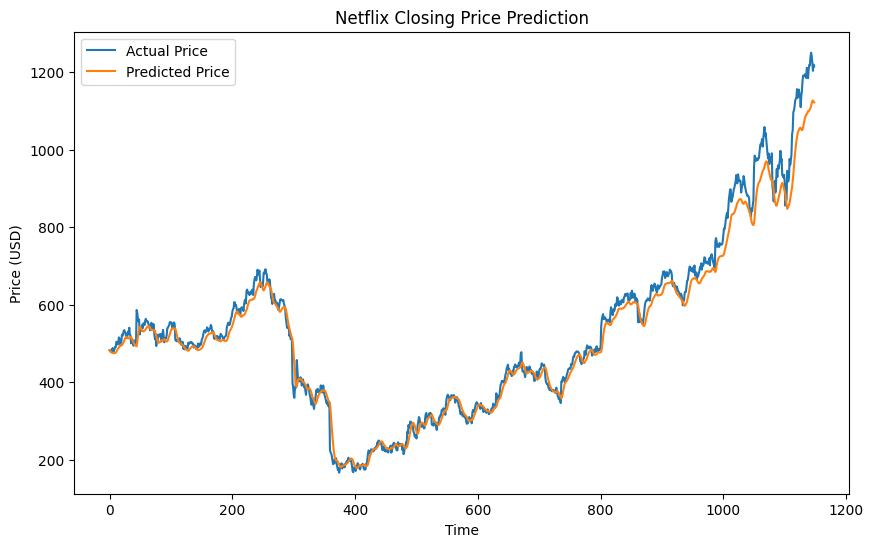

In [ ]:
pred_scaled = model.predict(X_test)
pred = scaler.inverse_transform(pred_scaled)
actual = scaler.inverse_transform(y_test.reshape(-1, 1))

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(actual, label='Actual Price')
plt.plot(pred, label='Predicted Price')
plt.title("Netflix Closing Price Prediction")
plt.xlabel("Time")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()


In [ ]:
model.save("netflix_lstm_model.h5")
